In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import flexynesis
import torch
torch.set_num_threads(10)

Seed set to 42


In [3]:
# parameters cell (required to pass arguments to the notebook) (see View -> show right sidebar -> add tag -> parameters)
HPO_ITER = 5 # number of HPO iterations for final modeling run

In [4]:
torch.cuda.is_available()  ## check if GPU is available

False

In [4]:
data_importer = flexynesis.DataImporter(path ='./brca_metabric_processed/', 
                                        data_types = ['gex', 'cna'], 
                                        concatenate=False, 
                                        top_percentile=10, 
                                        min_features=1000, 
                                        variance_threshold=0.8, # set to 0.8 for 80%   
                                       )
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ./brca_metabric_processed/train/gex.csv...


[INFO] Importing ./brca_metabric_processed/train/cna.csv...
[INFO] Importing ./brca_metabric_processed/train/clin.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ./brca_metabric_processed/test/gex.csv...
[INFO] Importing ./brca_metabric_processed/test/cna.csv...
[INFO] Importing ./brca_metabric_processed/test/clin.csv...

[INFO] ----------------- Checking for problems with the input data ----------------- 
[INFO] Data structure is valid with no errors or warnings.

[INFO] ----------------- Processing Data (train) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  gex
[INFO] Imputing NA values to median of features, affected # of cells in the matrix 7  # of rows: 5
[INFO] Number of NA values:  0
[INFO] DataFrame gex - Removed 16482 features.

[INFO] working on layer:  cna
[INFO] Imputing NA values to median of features, affected # of cells in the matrix 108  # of rows: 87
[INFO] Number of NA value

Filtering redundant features: 100%|██████████| 1000/1000 [00:00<00:00, 2394.55it/s]


[INFO] Implementing feature selection using laplacian score for layer: cna with  4509 features  and  1303  samples 


Filtering redundant features: 100%|██████████| 1000/1000 [00:00<00:00, 143768.56it/s]



[INFO] ----------------- Processing Data (test) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  gex
[INFO] Number of NA values:  0
[INFO] DataFrame gex - Removed 16482 features.

[INFO] working on layer:  cna
[INFO] Imputing NA values to median of features, affected # of cells in the matrix 63  # of rows: 51
[INFO] Number of NA values:  0
[INFO] DataFrame cna - Removed 18033 features.
[INFO] DataFrame gex - Removed 2 samples (0.36%).
[INFO] DataFrame cna - Removed 2 samples (0.36%).

[INFO] ----------------- Harmonizing Data Sets ----------------- 

[INFO] ----------------- Finished Harmonizing ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 
[INFO] Training Data Stats:  {'feature_count in: gex': 977, 'feature_count in: cna': 1000, 'sample_count': 1303}
[INFO] Test Data Stats:  {'feature_count in: gex': 977, 'feature_count in: cna': 

In [6]:
train_dataset.dat['gex'].shape, train_dataset.dat['cna'].shape

(torch.Size([1303, 977]), torch.Size([1303, 1000]))

In [7]:
train_dataset.ann

{'LYMPH_NODES_EXAMINED_POSITIVE': tensor([0, 0, 1,  ..., 1, 0, 0]),
 'NPI': tensor([4.0440, 4.0400, 5.0340,  ..., 5.0420, 3.0400, 4.0400],
        dtype=torch.float64),
 'AGE_AT_DIAGNOSIS': tensor([31.6000, 80.8200, 68.7600,  ..., 60.7400, 69.5600, 59.8400],
        dtype=torch.float64),
 'OS_MONTHS': tensor([282.3667,  64.3000, 177.2667,  ...,  45.8000, 237.5000,  55.0333],
        dtype=torch.float64),
 'RFS_MONTHS': tensor([278.6500,  63.4500, 174.9300,  ...,  29.9700,  26.8100,  54.3100],
        dtype=torch.float64),
 'CELLULARITY': tensor([0., nan, 0.,  ..., 0., 2., 2.], dtype=torch.float64),
 'CHEMOTHERAPY': tensor([0., 0., 0.,  ..., 1., 0., 0.], dtype=torch.float64),
 'COHORT': tensor([4., 2., 1.,  ..., 0., 2., 1.], dtype=torch.float64),
 'ER_IHC': tensor([0., 1., 1.,  ..., 0., 1., 1.], dtype=torch.float64),
 'HER2_SNP6': tensor([2., 2., 2.,  ..., 2., 1., 2.], dtype=torch.float64),
 'HORMONE_THERAPY': tensor([0., 1., 1.,  ..., 0., 0., 1.], dtype=torch.float64),
 'INFERRED_MENOP

In [25]:
train_dataset.label_mappings

{'CELLULARITY': {0: 'High', 1: 'Low', 2: 'Moderate', 3: nan},
 'CHEMOTHERAPY': {0: 'NO', 1: 'YES'},
 'COHORT': {0: 'cohort1',
  1: 'cohort2',
  2: 'cohort3',
  3: 'cohort4',
  4: 'cohort5'},
 'ER_IHC': {0: 'Negative', 1: 'Positve', 2: nan},
 'HER2_SNP6': {0: 'GAIN', 1: 'LOSS', 2: 'NEUTRAL', 3: 'UNDEF'},
 'HORMONE_THERAPY': {0: 'NO', 1: 'YES'},
 'INFERRED_MENOPAUSAL_STATE': {0: 'Post', 1: 'Pre'},
 'SEX': {0: 'Female'},
 'INTCLUST': {0: '1',
  1: '10',
  2: '2',
  3: '3',
  4: '4ER+',
  5: '4ER-',
  6: '5',
  7: '6',
  8: '7',
  9: '8',
  10: '9'},
 'OS_STATUS': {0: '0:LIVING', 1: '1:DECEASED'},
 'CLAUDIN_SUBTYPE': {0: 'Basal',
  1: 'Her2',
  2: 'LumA',
  3: 'LumB',
  4: 'NC',
  5: 'Normal',
  6: 'claudin-low'},
 'THREEGENE': {0: 'ER+/HER2- High Prolif',
  1: 'ER+/HER2- Low Prolif',
  2: 'ER-/HER2-',
  3: 'HER2+',
  4: nan},
 'VITAL_STATUS': {0: 'Died of Disease',
  1: 'Died of Other Causes',
  2: 'Living',
  3: nan},
 'LATERALITY': {0: 'Left', 1: 'Right', 2: nan},
 'RADIO_THERAPY': {0: 

In [10]:
train_dataset.samples[1:10], train_dataset.features

(['MB-4654',
  'MB-2686',
  'MB-7124',
  'MB-0365',
  'MB-2990',
  'MB-0174',
  'MB-5502',
  'MB-3085',
  'MB-2643'],
 {'cna': Index(['MSTO2P', 'FCRLA', 'TOP1P1', 'LAMC1', 'TDRKH', 'ZNF678', 'CRB1',
         'BPNT1', 'LINC00467', 'DSTYK',
         ...
         'ANKRD34A', 'IL19', 'CLDN6', 'CCDC64B', 'THOC6', 'CLDN9', 'HCFC1R1',
         'TNFRSF12A', 'ADSS', 'DESI2'],
        dtype='object', length=1000),
  'gex': Index(['FOXA1', 'MLPH', 'ESR1', 'GATA3', 'SPDEF', 'TBC1D9', 'FOXC1', 'C1S',
         'XBP1', 'CA12',
         ...
         'EXO5', 'CHRNA5', 'TRIM13', 'SHROOM4', 'CYB5RL', 'CDKN2AIPNL', 'TMEM17',
         'CD19', 'TDP1', 'ZNF549'],
        dtype='object', length=977)})

In [11]:
flexynesis.print_summary_stats(train_dataset)

Summary for variable: LYMPH_NODES_EXAMINED_POSITIVE
Numerical Variable Summary: Median = 0.0, Mean = 1.9286262471220261
------
Summary for variable: NPI
Numerical Variable Summary: Median = 4.04, Mean = 4.017291158864159
------
Summary for variable: AGE_AT_DIAGNOSIS
Numerical Variable Summary: Median = 61.79, Mean = 61.30643898695319
------
Summary for variable: OS_MONTHS
Numerical Variable Summary: Median = 114.4666667, Mean = 125.03573804066693
------
Summary for variable: RFS_MONTHS
Numerical Variable Summary: Median = 100.63, Mean = 109.94034535686878
------
Summary for variable: CELLULARITY
Categorical Variable Summary:
  Label: High, Count: 656
  Label: Low, Count: 136
  Label: Moderate, Count: 484
  Label: nan, Count: 27
------
Summary for variable: CHEMOTHERAPY
Categorical Variable Summary:
  Label: NO, Count: 1044
  Label: YES, Count: 259
------
Summary for variable: COHORT
Categorical Variable Summary:
  Label: cohort1, Count: 308
  Label: cohort2, Count: 196
  Label: cohort3

In [26]:
tuner = flexynesis.HyperparameterTuning(dataset = train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = ["CLAUDIN_SUBTYPE", "CHEMOTHERAPY", "ER_IHC"],
                                        config_name = "DirectPred", 
                                        n_iter=HPO_ITER,plot_losses=True, early_stop_patience=20) 

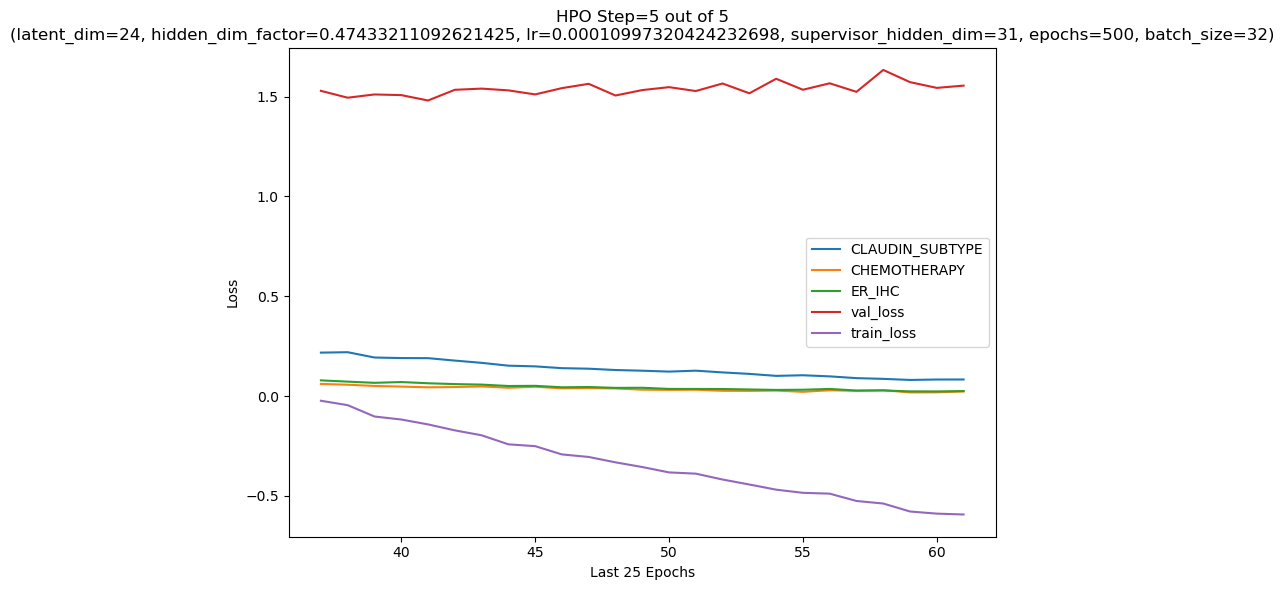

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       CHEMOTHERAPY        │     0.590980589389801     │
│      CLAUDIN_SUBTYPE      │    0.6880034804344177     │
│          ER_IHC           │    0.2760125696659088     │
│         val_loss          │    1.5549966096878052     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 5/5 [04:01<00:00, 48.35s/it, Iteration=5, Best Loss=1.33]

[INFO] current best val loss: 1.334804654121399; best params: {'latent_dim': np.int64(64), 'hidden_dim_factor': 0.327498572125959, 'lr': 0.0001912302884076495, 'supervisor_hidden_dim': np.int64(20), 'epochs': 500, 'batch_size': np.int64(128)} since 1 hpo iterations


In [27]:
model, best_params = tuner.perform_tuning()

In [28]:
model

DirectPred(
  (log_vars): ParameterDict(
      (CLAUDIN_SUBTYPE): Parameter containing: [torch.FloatTensor of size 1]
      (CHEMOTHERAPY): Parameter containing: [torch.FloatTensor of size 1]
      (ER_IHC): Parameter containing: [torch.FloatTensor of size 1]
  )
  (encoders): ModuleList(
    (0): MLP(
      (layer_1): Linear(in_features=1000, out_features=327, bias=True)
      (layer_out): Linear(in_features=327, out_features=64, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(327, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MLP(
      (layer_1): Linear(in_features=977, out_features=319, bias=True)
      (layer_out): Linear(in_features=319, out_features=64, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(319, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (MLPs): ModuleDict(
    (CLAUDIN_SUBTYPE): ML

In [29]:
best_params

{'latent_dim': np.int64(64),
 'hidden_dim_factor': 0.327498572125959,
 'lr': 0.0001912302884076495,
 'supervisor_hidden_dim': np.int64(20),
 'epochs': 171,
 'batch_size': np.int64(128)}

In [30]:
y_pred_dict = model.predict(test_dataset)

In [31]:
y_pred_dict

{'CLAUDIN_SUBTYPE': array([[0.00648947, 0.01368986, 0.02379682, ..., 0.01773986, 0.00756918,
         0.01150405],
        [0.02715653, 0.03426361, 0.27476063, ..., 0.04102144, 0.45503232,
         0.16336061],
        [0.29805848, 0.01023471, 0.01389186, ..., 0.02418418, 0.03021562,
         0.62081856],
        ...,
        [0.8096962 , 0.04893028, 0.02422385, ..., 0.01598772, 0.023546  ,
         0.06717719],
        [0.006701  , 0.03200933, 0.8980431 , ..., 0.01166874, 0.02162143,
         0.01429474],
        [0.06084763, 0.16973722, 0.4702297 , ..., 0.03398618, 0.21121019,
         0.03329163]], dtype=float32),
 'CHEMOTHERAPY': array([[0.95223784, 0.0477621 ],
        [0.875206  , 0.12479399],
        [0.00179221, 0.9982078 ],
        ...,
        [0.00887646, 0.99112356],
        [0.68009317, 0.3199068 ],
        [0.54718757, 0.45281237]], dtype=float32),
 'ER_IHC': array([[0.00257057, 0.99357516, 0.00385431],
        [0.00753145, 0.9792007 , 0.01326785],
        [0.9908853 , 0.

In [32]:
metrics_df = flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=y_pred_dict, dataset = test_dataset)
metrics_df

,method,var,variable_type,metric,value
0,DirectPred,CLAUDIN_SUBTYPE,categorical,balanced_acc,0.574488
1,DirectPred,CLAUDIN_SUBTYPE,categorical,f1_score,0.723768
2,DirectPred,CLAUDIN_SUBTYPE,categorical,kappa,0.645915
3,DirectPred,CLAUDIN_SUBTYPE,categorical,average_auroc,0.940879
4,DirectPred,CLAUDIN_SUBTYPE,categorical,average_aupr,0.823683
5,DirectPred,CHEMOTHERAPY,categorical,balanced_acc,0.730415
6,DirectPred,CHEMOTHERAPY,categorical,f1_score,0.807057
7,DirectPred,CHEMOTHERAPY,categorical,kappa,0.449186
8,DirectPred,CHEMOTHERAPY,categorical,average_auroc,0.817210
9,DirectPred,CHEMOTHERAPY,categorical,average_aupr,0.592032


In [5]:
test_dataset

In [33]:
ds = test_dataset
E = model.transform(ds)
E.head()

,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,E118,E119,E120,E121,E122,E123,E124,E125,E126,E127
MB-0589,0.907169,0.591497,-0.320943,0.210951,0.729172,-0.314399,-0.590327,-0.742651,-0.816899,0.928371,...,0.384271,0.609328,-0.944930,-0.173213,0.742687,-0.229063,-0.225825,-0.670174,0.891669,-0.287103
MB-0377,0.097667,0.157748,0.092128,0.089273,0.121903,0.174570,-0.031891,-0.061985,-0.109474,0.113621,...,0.318728,-0.780039,0.033606,0.904962,0.444322,-0.014475,-0.847085,2.080852,0.264198,-0.701618
MB-5616,-0.126277,0.427077,0.272543,-0.255892,-0.305333,0.066831,-0.361370,0.061203,-0.047745,0.016489,...,0.689444,-0.889043,-0.075687,-0.068250,0.190215,0.146718,-0.091536,0.454418,0.757967,0.216589
MB-7082,-0.030952,0.359535,-0.181722,0.086390,-0.494527,0.015292,-0.176793,-0.029076,-0.996626,-0.008169,...,0.466348,-0.558432,-0.432125,-0.273128,1.152129,-0.496753,0.861751,-0.954749,0.593775,0.238710
MB-6217,0.747705,0.204926,-0.811320,0.107035,0.144385,0.017082,-0.604098,-0.724905,-0.805155,0.457664,...,0.246752,0.241344,0.054396,-0.354188,0.748286,-0.374782,-0.466166,-0.244482,1.001311,-0.220236


In [8]:
test_dataset.label_mappings['CLAUDIN_SUBTYPE']

{0: 'Basal',
 1: 'Her2',
 2: 'LumA',
 3: 'LumB',
 4: 'NC',
 5: 'Normal',
 6: 'claudin-low'}

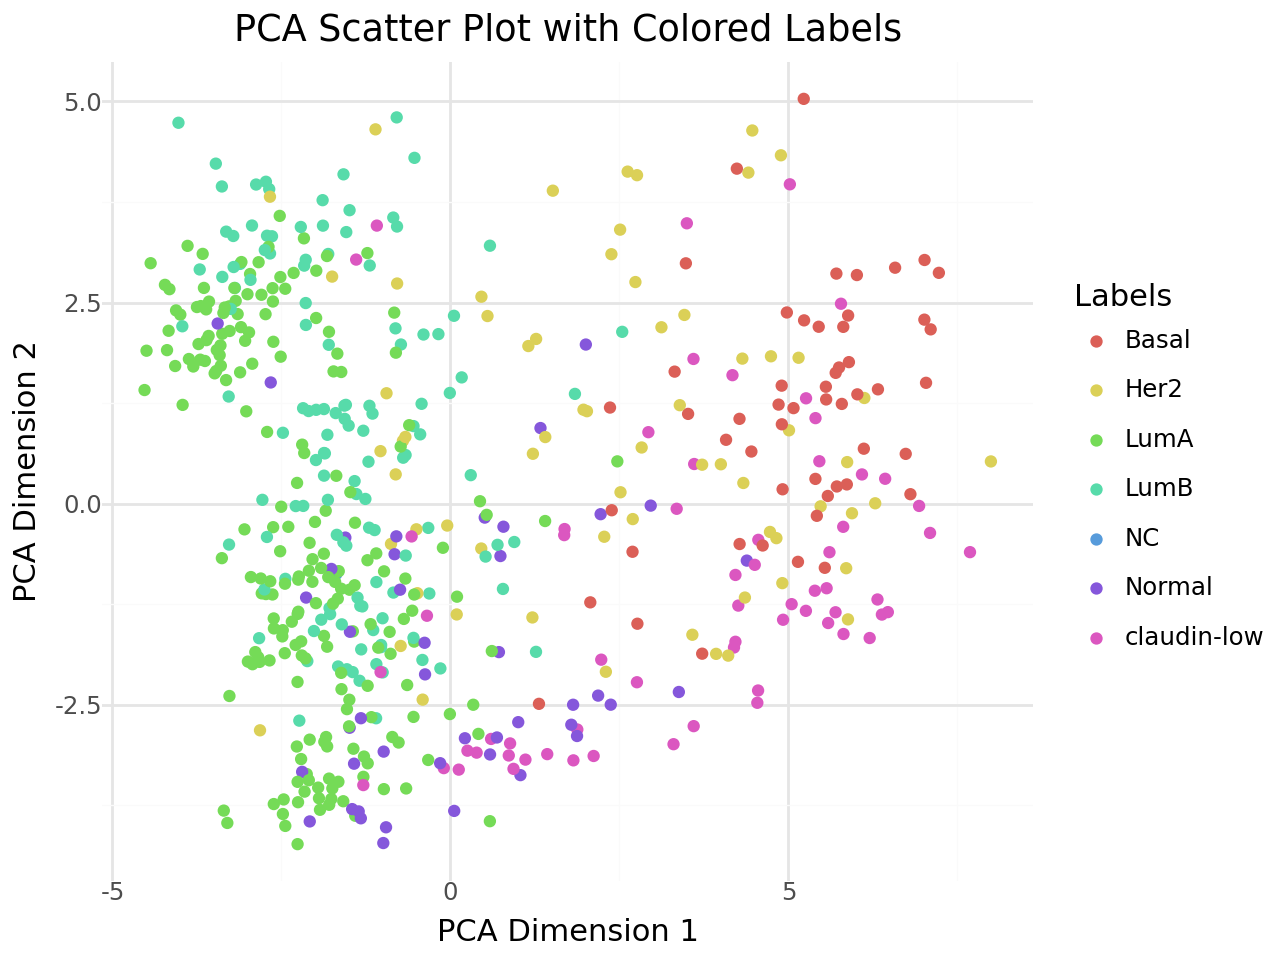

In [34]:
f = 'CLAUDIN_SUBTYPE'
labels = [ds.label_mappings[f][x] for x in ds.ann[f].numpy()] #map the sample labels from numeric vector to initial labels. 
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='pca')

/public/home/liujunwu/software/miniconda3/envs/ame/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


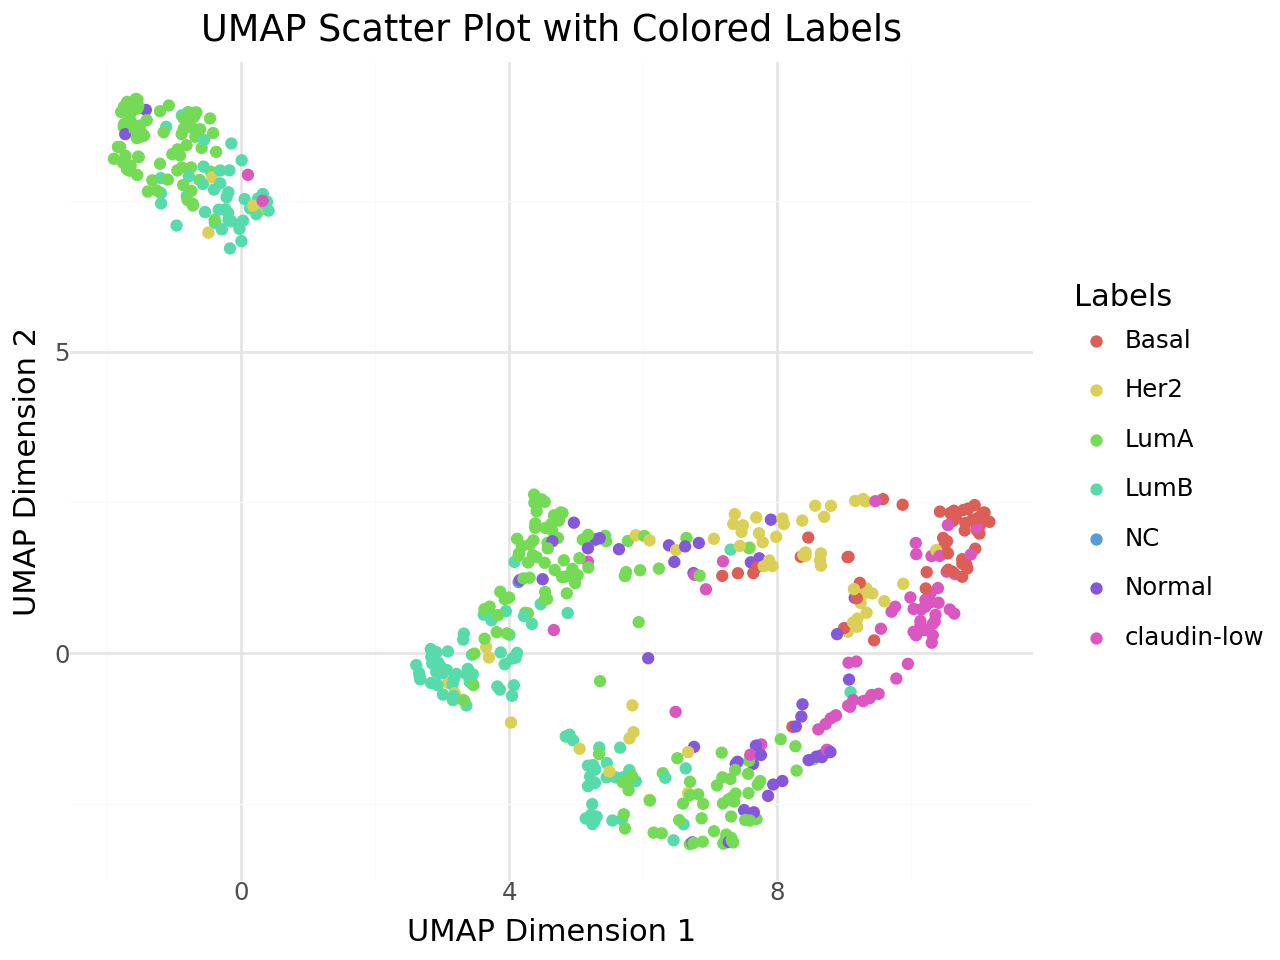

In [35]:
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='umap')

/public/home/liujunwu/software/miniconda3/envs/ame/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


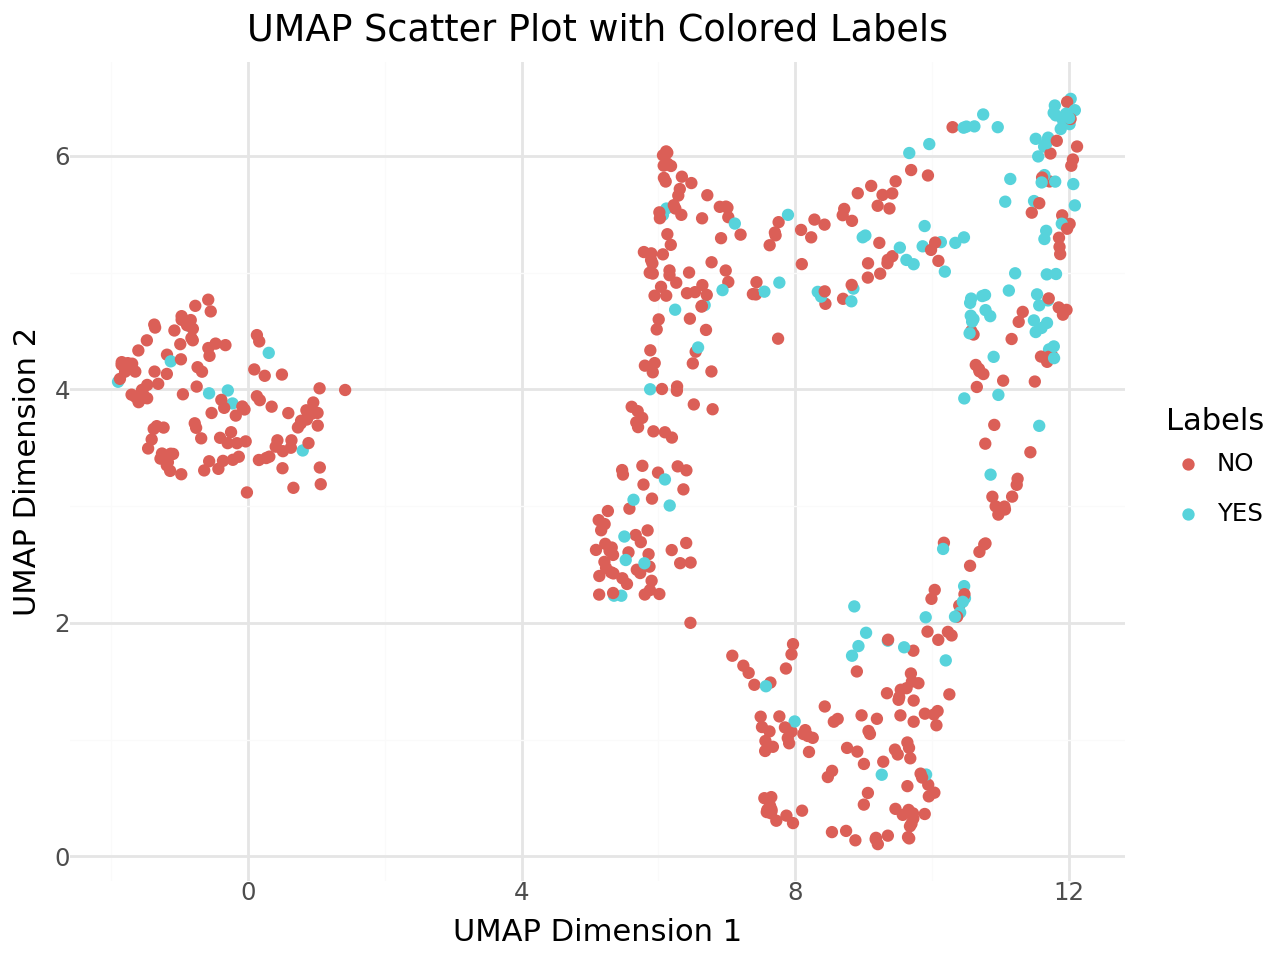

In [39]:
f = 'CHEMOTHERAPY'
labels = [ds.label_mappings[f][x] for x in ds.ann[f].numpy()] #map the sample labels from numeric vector to initial labels. 
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='umap')

/public/home/liujunwu/software/miniconda3/envs/ame/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


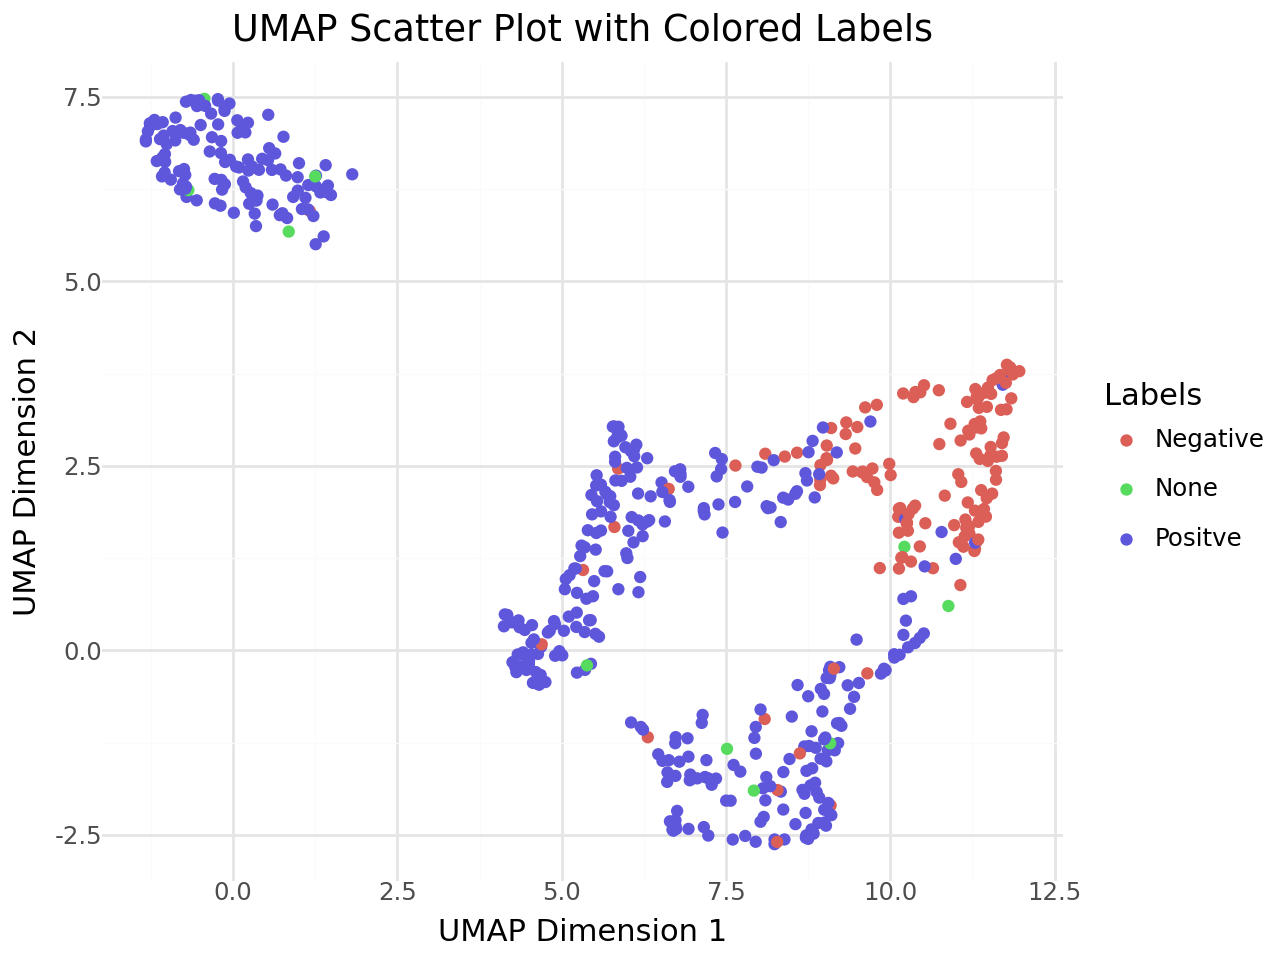

In [49]:
import numpy as np
f = 'ER_IHC'
labels = [ds.label_mappings[f][x] if not np.isnan(x) else 'None' for x in ds.ann[f].numpy()] #map the sample labels from numeric vector to initial labels. 
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='umap')